In [46]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import scatter_matrix

In [47]:
SEED = 1234

In [48]:
np.random.seed(SEED)
random.seed(SEED)

In [49]:
dataset = "./dataset/tumors.csv"
df = pd.read_csv(dataset, header=0)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [50]:
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1000, 2)
y:  (1000,)


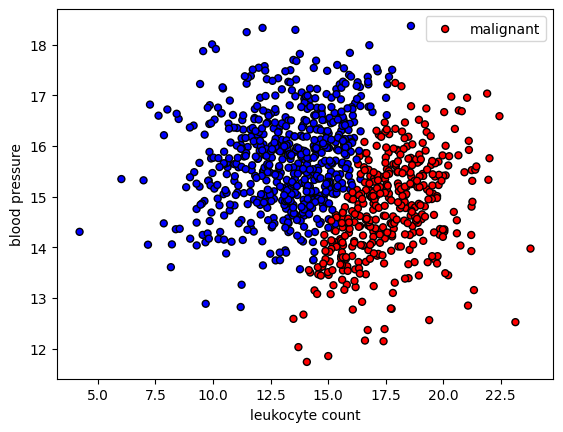

In [51]:
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()

In [52]:
import collections
from sklearn.model_selection import train_test_split

In [53]:
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [54]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [55]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


In [56]:
from sklearn.preprocessing import LabelEncoder

In [57]:
label_encoder = LabelEncoder()

In [58]:
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")

classes: ['benign', 'malignant']


In [59]:
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: malignant
y_train[0]: 1


In [60]:
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
X_scaler = StandardScaler().fit(X_train)

In [63]:
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [64]:
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


In [65]:
import torch
from torch import nn
import torch.nn.functional as F

In [66]:
torch.manual_seed(SEED)

In [67]:
INPUT_DIM = 2 
HIDDEN_DIM = 100
NUM_CLASSES = 2

In [68]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = F.relu(self.fc1(x_in)) 
        z = self.fc2(z)
        return z

In [69]:
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>


In [70]:
from torch.optim import Adam

In [71]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
BATCH_SIZE = 32

In [72]:
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [73]:
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [74]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [75]:
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [76]:
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.70, accuracy: 48.4
Epoch: 10 | loss: 0.54, accuracy: 92.3
Epoch: 20 | loss: 0.43, accuracy: 97.4
Epoch: 30 | loss: 0.35, accuracy: 97.4
Epoch: 40 | loss: 0.30, accuracy: 97.4


In [77]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [78]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    performance = {"overall": {}, "class": {}}

    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [79]:
y_prob = F.softmax(model(X_test), dim=1)
y_pred = y_prob.max(dim=1)[1]

In [80]:
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9666478023014525,
    "recall": 0.9666666666666667,
    "f1": 0.9666118292205249,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 0.9649122807017544,
      "recall": 0.9482758620689655,
      "f1": 0.9565217391304347,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.967741935483871,
      "recall": 0.9782608695652174,
      "f1": 0.972972972972973,
      "num_samples": 92.0
    }
  }
}


In [81]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

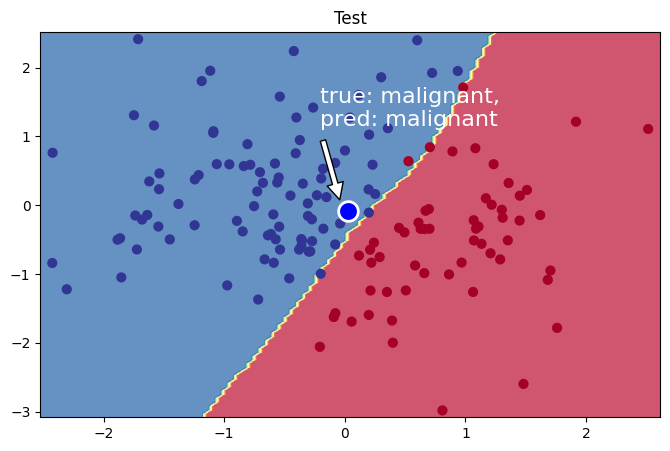

In [82]:
plt.figure(figsize=(8,5))
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)

mean_leukocyte_count, mean_blood_pressure = X_scaler.transform(
    [[np.mean(df.leukocyte_count), np.mean(df.blood_pressure)]])[0]
plt.scatter(mean_leukocyte_count+0.05, mean_blood_pressure-0.05, s=200,
            c="b", edgecolor="w", linewidth=2)

plt.annotate("true: malignant,\npred: malignant",
             color="white",
             xy=(mean_leukocyte_count, mean_blood_pressure),
             xytext=(0.4, 0.65),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor="white", shrink=0.1))
plt.show()

In [83]:
dataset = "./dataset/tumors_reduced.csv"
df_reduced = pd.read_csv(dataset, header=0)
df_reduced = df_reduced.sample(frac=1).reset_index(drop=True)
df_reduced.head()

,leukocyte_count,blood_pressure,tumor_class
0,16.795186,14.434741,benign
1,13.472969,15.250393,malignant
2,9.840450,16.434717,malignant
3,16.390730,14.419258,benign
4,13.367974,15.741790,malignant


In [84]:
X = df_reduced[["leukocyte_count", "blood_pressure"]].values
y = df_reduced["tumor_class"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (720, 2)
y:  (720,)


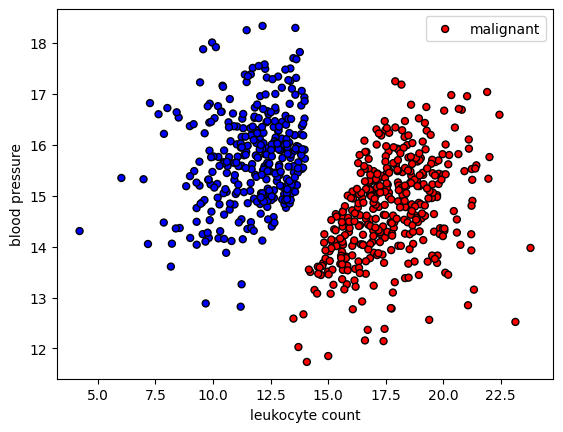

In [85]:
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()

In [86]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (503, 2), y_train: (503,)
X_val: (108, 2), y_val: (108,)
X_test: (109, 2), y_test: (109,)
Sample point: [18.34509397 14.25516163] → benign


In [87]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
num_classes = len(label_encoder.classes_)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [88]:
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 231]
weights: {0: 0.003676470588235294, 1: 0.004329004329004329}


In [89]:
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [90]:
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)

In [91]:
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [92]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [93]:
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [94]:
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.67, accuracy: 71.4
Epoch: 10 | loss: 0.52, accuracy: 96.8
Epoch: 20 | loss: 0.41, accuracy: 100.0
Epoch: 30 | loss: 0.33, accuracy: 100.0
Epoch: 40 | loss: 0.27, accuracy: 100.0


In [95]:
y_prob = F.softmax(model(X_test), dim=1)
y_pred = y_prob.max(dim=1)[1]

In [96]:
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 109.0
  },
  "class": {
    "benign": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 59.0
    },
    "malignant": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 50.0
    }
  }
}


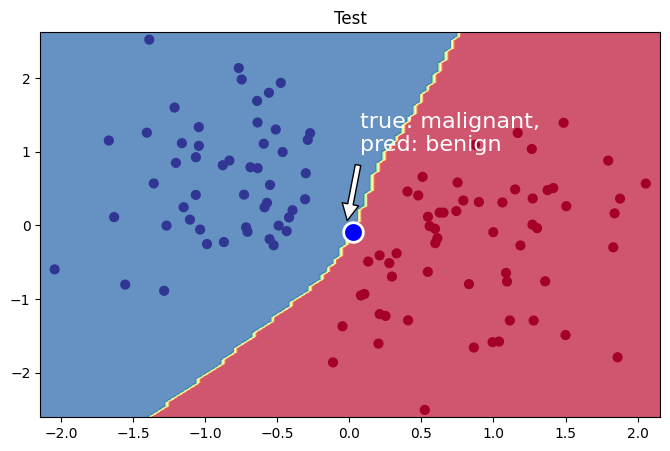

In [97]:
plt.figure(figsize=(8,5))
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)

# Sample point near the decision boundary (same point as before)
plt.scatter(mean_leukocyte_count+0.05, mean_blood_pressure-0.05, s=200,
            c="b", edgecolor="w", linewidth=2)

# Annotate
plt.annotate("true: malignant,\npred: benign",
             color="white",
             xy=(mean_leukocyte_count, mean_blood_pressure),
             xytext=(0.45, 0.60),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor="white", shrink=0.1))
plt.show()

In [ ]:
"""
@article{madewithml,
    author       = {Goku Mohandas},
    title        = { Data quality - Made With ML },
    howpublished = {\url{https://madewithml.com/}},
    year         = {2023}
}
"""